## Lectura 8-3: Colinealidad





## Colinealidad exacta

Vamos a crear un conjunto de datos donde uno de los predictores, $x_3$, es una combinación lineal de los otros predictores.


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr

In [2]:
np.random.seed(42)

def gen_exact_collin_data(num_samples=100):
    x1 = np.random.normal(loc=80, scale=10, size=num_samples)
    x2 = np.random.normal(loc=70, scale=5, size=num_samples)
    x3 = 2 * x1 + 4 * x2 + 3
    y = 3 + x1 + x2 + np.random.normal(loc=0, scale=1, size=num_samples)
    return pd.DataFrame({'y': y, 'x1': x1, 'x2': x2, 'x3': x3})


Observe que, de la forma en que estamos generando estos datos, la respuesta $y$ sólo depende realmente de $x_1$ y $x_2$.


In [3]:
exact_collin_data = gen_exact_collin_data()
print(exact_collin_data.head())

            y         x1         x2          x3
0  151.248075  84.967142  62.923146  424.626868
1  150.074915  78.617357  67.896773  431.821808
2  158.846364  86.476885  68.286427  449.099480
3  165.272714  95.230299  65.988614  457.415052
4  148.474368  77.658466  69.193571  435.091218



¿Qué ocurre cuando intentamos ajustar un modelo de regresión en `Python` utilizando todos los predictores?


In [4]:
X = sm.add_constant(exact_collin_data.drop(columns='y'))
model = sm.OLS(exact_collin_data['y'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     4146.
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           1.15e-94
Time:                        09:51:17   Log-Likelihood:                -147.62
No. Observations:                 100   AIC:                             301.2
Df Residuals:                      97   BIC:                             309.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4127      1.392      0.297      0.7


Vemos que `Python` simplemente decide excluir una variable. ¿Por qué sucede?


In [5]:
print(np.linalg.inv(X.T @ X))

[[-9.65821262e+08 -6.43880844e+08 -1.28776169e+09  3.21940422e+08]
 [-6.43880844e+08 -4.29253896e+08 -8.58507791e+08  2.14626948e+08]
 [-1.28776169e+09 -8.58507791e+08 -1.71701558e+09  4.29253896e+08]
 [ 3.21940422e+08  2.14626948e+08  4.29253896e+08 -1.07313474e+08]]



Si intentamos encontrar $\boldsymbol{\hat{\beta}}$ utilizando
$\left( \boldsymbol{X}^T \boldsymbol{X} \right)^{-1}$, vemos que esto no es posible, debido a que las columnas de $\boldsymbol{X}$ son linealmente dependientes. Las líneas de código anteriores no se han ejecutado, ¡porque producen un error!

Cuando esto ocurre, decimos que hay **colinealidad exacta** en el conjunto de datos.

Como resultado de este problema, `Python` esencialmente eligió ajustar el modelo `y ~ x1 + x2`. Sin embargo, observe que otros dos modelos lograrían exactamente el mismo ajuste.


In [6]:
model1 = sm.OLS(exact_collin_data['y'], sm.add_constant(exact_collin_data[['x1', 'x2']])).fit()
model2 = sm.OLS(exact_collin_data['y'], sm.add_constant(exact_collin_data[['x1', 'x3']])).fit()
model3 = sm.OLS(exact_collin_data['y'], sm.add_constant(exact_collin_data[['x2', 'x3']])).fit()



Vemos que los valores ajustados para cada uno de los tres modelos son exactamente los mismos. Esto se debe a que $x_3$ contiene toda la información de $x_1$ y $x_2$. Mientras una de $x_1$ o $x_2$ esté incluida en el modelo, $x_3$ puede utilizarse para recuperar la información de la variable no incluida.


In [7]:
print(np.allclose(model1.fittedvalues, model2.fittedvalues))
print(np.allclose(model2.fittedvalues, model3.fittedvalues))

True
True



Aunque sus valores ajustados son todos iguales, sus coeficientes estimados son muy diferentes. El signo de $x_2$ cambia en dos de los modelos. Así que sólo `fit1` *explica* correctamente la relación entre las variables, `fit2` y `fit3` aún *predicen* tan bien como `fit1`, a pesar de que los coeficientes tienen poco o ningún significado, un concepto al que volveremos más adelante.


In [8]:
print(model1.params)

const    1.451809
x1       1.022609
x2       0.997545
dtype: float64


In [9]:
print(model2.params)

const    0.703650
x1       0.523837
x3       0.249386
dtype: float64


In [10]:
print(model3.params)

const   -0.082105
x2      -1.047673
x3       0.511304
dtype: float64



## Colinealidad

La colinealidad exacta es un ejemplo extremo de **colinealidad**, que se produce en la regresión múltiple cuando las variables predictoras están muy correlacionadas. La colinealidad a menudo se denomina *colinealidad múltiple*, ya que es un fenómeno que realmente sólo se produce durante la regresión múltiple.

Si observamos el conjunto de datos `seatpos` del paquete `faraway`, veremos un ejemplo de este concepto. Los predictores de este conjunto de datos son varios atributos de los conductores de coches, como su altura, peso y edad. La variable de respuesta `centro de la cadera` mide la "distancia horizontal del punto medio de las caderas desde un lugar fijo del coche en mm". Esencialmente, mide la posición del asiento para un conductor determinado. Se trata de una información potencialmente útil para los fabricantes de automóviles que tengan en cuenta la comodidad y la seguridad a la hora de diseñar los vehículos.

Intentaremos ajustar un modelo que prediga el `centro de la cadera`. Hay dos variables predictoras que nos interesan de inmediato: `HtShoes` y `Ht`. Ciertamente esperamos que la altura de una persona esté altamente correlacionada con su altura cuando lleva zapatos. Prestaremos especial atención a estas dos variables a la hora de ajustar los modelos.


In [11]:
import faraway.utils
import faraway.datasets.seatpos   

In [12]:
# cargar base de datos de ejemplo

seatpos = faraway.datasets.seatpos.load()
seatpos.head(20)

,Age,Weight,HtShoes,Ht,Seated,Arm,Thigh,Leg,hipcenter
0,46,180,187.2,184.9,95.2,36.1,45.3,41.3,-206.300
1,31,175,167.5,165.5,83.8,32.9,36.5,35.9,-178.210
2,23,100,153.6,152.2,82.9,26.0,36.6,31.0,-71.673
3,19,185,190.3,187.4,97.3,37.4,44.1,41.0,-257.720
4,23,159,178.0,174.1,93.9,29.5,40.1,36.9,-173.230
5,47,170,178.7,177.0,92.4,36.0,43.2,37.4,-185.150
6,30,137,165.7,164.6,87.7,32.5,35.6,36.2,-164.750
7,28,192,185.3,182.7,96.9,35.8,39.9,43.1,-270.920
8,23,150,167.6,165.0,91.4,29.4,35.5,33.4,-151.780
9,29,120,161.2,158.7,85.2,26.6,31.0,32.8,-113.880


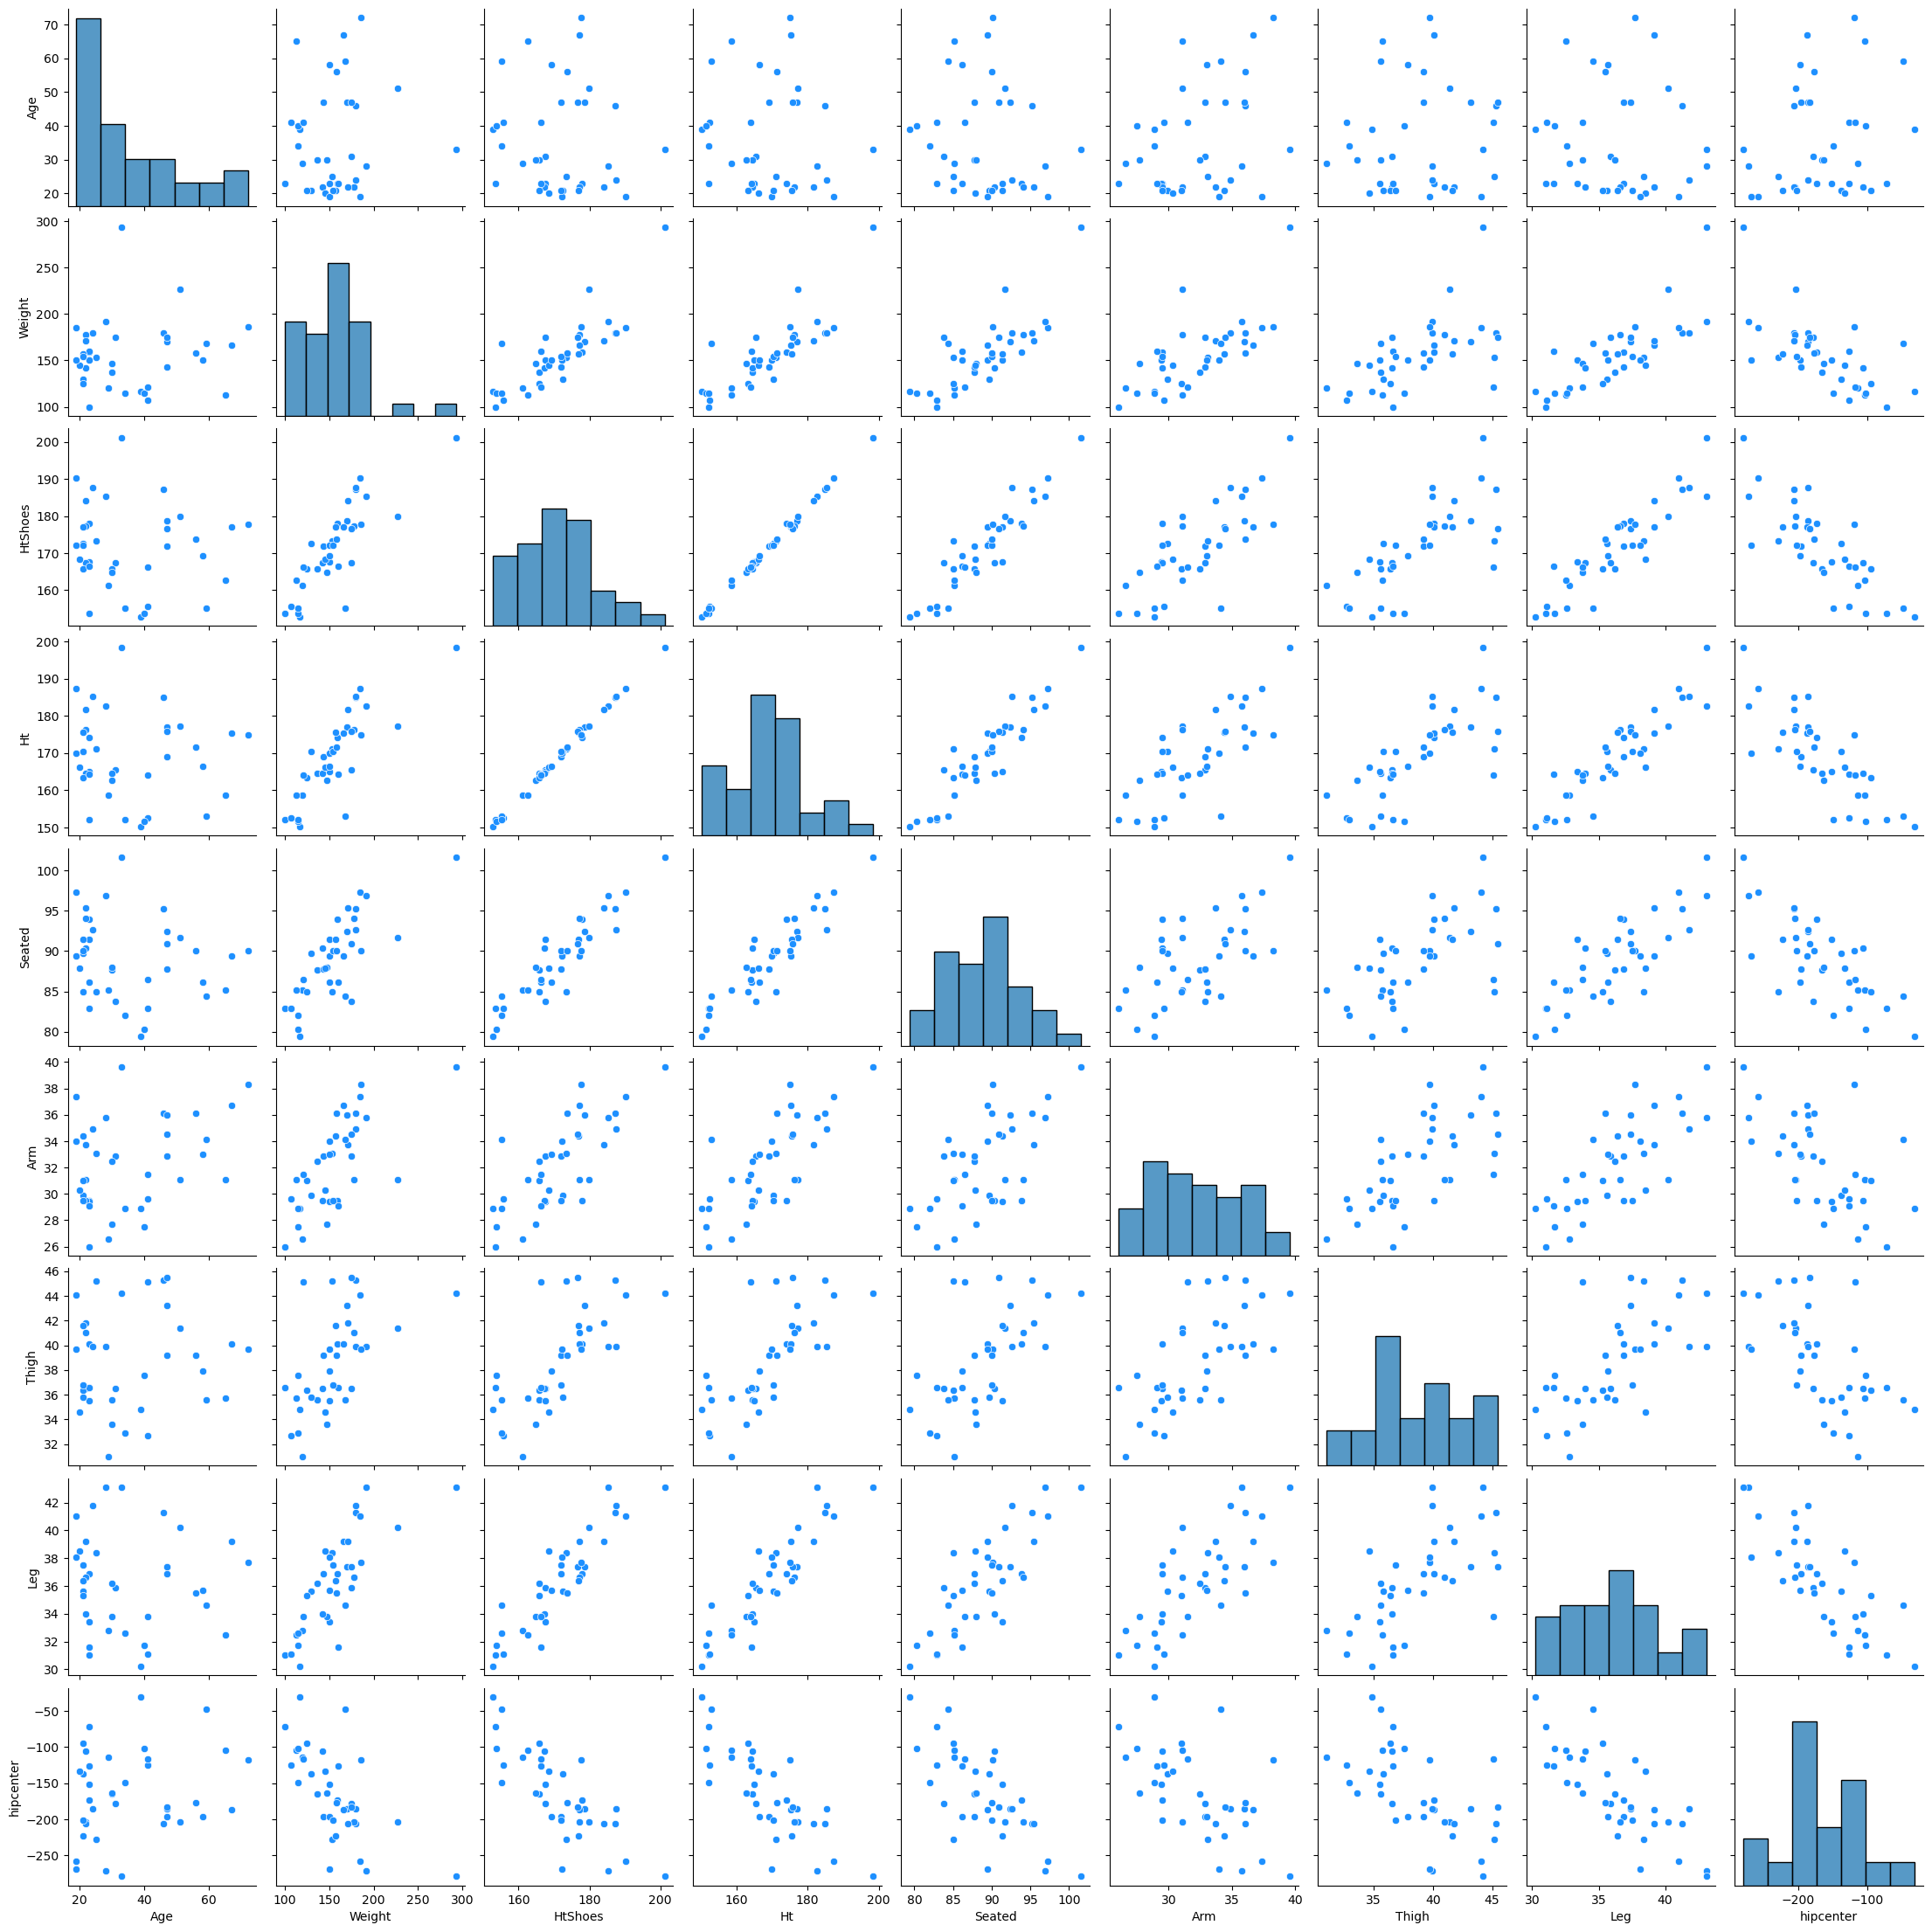

In [13]:
import seaborn as sns
# Create a pairplot
sns.pairplot(seatpos, plot_kws={'color': 'dodgerblue'})

In [14]:
# Create a correlation matrix and heatmap
corr = seatpos.corr()
sns.heatmap(corr, cmap='Blues', annot=True)

<AxesSubplot:>


Después de cargar el paquete `faraway`, hacemos algunas comprobaciones rápidas de la correlación entre los predictores. Visualmente, podemos hacerlo con la función `pairs()`, que traza todos los diagramas de dispersión posibles entre pares de variables en el conjunto de datos.

También podemos hacerlo numéricamente con la función `cor()`, que cuando se aplica a un conjunto de datos, devuelve todas las correlaciones por pares. Observe que se trata de una matriz simétrica. Recordemos que la correlación mide la fuerza y dirección de la relación lineal entre dos variables. La correlación correlación entre `Ht` y `HtShoes` es extremadamente alta. Tan alta, que redondeada a dos decimales, ¡parece 1!

A diferencia de la colinealidad exacta, aquí aún podemos ajustar un modelo con todos los predictores, pero ¿qué efecto tiene esto?


In [15]:
# hip_model
X_hip = sm.add_constant(seatpos.drop(columns='hipcenter'))
hip_model = sm.OLS(seatpos['hipcenter'], X_hip).fit()
print(hip_model.summary())

                            OLS Regression Results                            
Dep. Variable:              hipcenter   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     7.940
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           1.31e-05
Time:                        09:51:27   Log-Likelihood:                -186.73
No. Observations:                  38   AIC:                             391.5
Df Residuals:                      29   BIC:                             406.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        436.4321    166.572      2.620      0.0


Una de las primeras cosas que debemos observar es que la prueba $F$ para la regresión nos dice que la regresión es significativa, sin embargo cada predictor individual no lo es. Otro resultado interesante son los signos opuestos de los coeficientes de `Ht`  y `HtShoes`. Esto debería parecer contrario a la intuición. ¿Aumentar `Ht` aumenta el `centro de la cadera`, pero aumentar `HtShoes` disminuye el `centro de la cadera`?

Esto ocurre porque los predictores están muy correlacionados. Por ejemplo, la variable `HtShoe` explica una gran parte de la variación en `Ht`. Cuando ambas están en el modelo, sus efectos sobre la respuesta disminuyen individualmente, pero juntas siguen explicando una gran parte de la variación del `centro de la cadera`.

Definimos $R_j^2$ como la proporción de la variación observada en el predictor $j$ º explicada por los otros predictores. En otras palabras, $R_j^2$ es la R-cuadrado múltiple para la regresión de $x_j$ en cada uno de los otros predictores.



In [16]:
# ht_shoes_model
X_shoes = sm.add_constant(seatpos.drop(columns=['hipcenter', 'HtShoes']))
ht_shoes_model = sm.OLS(seatpos['HtShoes'], X_shoes).fit()
print(ht_shoes_model.rsquared)

0.9967472204300996



Aquí vemos que los otros predictores explican $99,67%$ de la variación en `HtShoe`. Al ajustar este modelo, eliminamos `hipcenter` ya que no es un predictor.



### Factor de Inflación de la Varianza.

Observe ahora que la varianza de $\hat{\beta_j}$ puede escribirse como

$$
\text{Var}(\hat{\beta_j}) = \sigma^2 C_{jj} = \sigma^2 \left( \frac{1}{1 - R_j^2}  \right) \frac{1}{S_{x_j x_j}}
$$

donde

$$
S_{x_j x_j} = \sum(x_{ij}-\bar{x}_j)^2.
$$

Esto nos da una manera de entender cómo la colinealidad afecta a nuestras estimaciones de regresión.

Vamos a llamar,

$$
\frac{1}{1 - R_j^2}
$$

a varianza de nuestras estimaciones de regresión. Cuando $R_j^2$ es grande, es decir, cerca de 1, $x_j$ está bien explicado por los otros predictores. Con un gran $R_j^2$ el factor de inflación de la varianza se hace grande. Esto nos dice que cuando $x_j$ está muy correlacionada con otros predictores, nuestra estimación de $\beta_j$ es muy variable.

La función `vif` del paquete `faraway` calcula los VIF para cada uno de los predictores de un modelo.


In [17]:
# VIF
vif_data = pd.Series([variance_inflation_factor(X_hip.values, i) for i in range(X_hip.shape[1])], index=X_hip.columns)
print(vif_data)


const      741.029693
Age          1.997931
Weight       3.647030
HtShoes    307.429378
Ht         333.137832
Seated       8.951054
Arm          4.496368
Thigh        2.762886
Leg          6.694291
dtype: float64



En la práctica, se suele decir que cualquier VIF superior a $5$ es motivo de preocupación. Así pues, en este ejemplo vemos que hay un gran problema de multicolinealidad, ya que muchos de los predictores tienen un VIF superior a
$5$.

Investiguemos más a fondo cómo la presencia de colinealidad afecta realmente a un modelo. Si añadimos una cantidad moderada de ruido a los datos, vemos que las estimaciones de los coeficientes cambian drásticamente. Se trata de un efecto bastante indeseable. Añadir ruido aleatorio no debería afectar a los coeficientes de un modelo.


In [18]:
# hip_model_noise
np.random.seed(1337)
noise = np.random.normal(loc=0, scale=5, size=seatpos.shape[0])
hip_model_noise = sm.OLS(seatpos['hipcenter'] + noise, X_hip).fit()



La adición de ruido ha tenido un efecto tan grande que el signo del coeficiente de `Ht` ha cambiado.


In [19]:
print(hip_model.params)
print(hip_model_noise.params)

const      436.432128
Age          0.775716
Weight       0.026313
HtShoes     -2.692408
Ht           0.601345
Seated       0.533752
Arm         -1.328069
Thigh       -1.143119
Leg         -6.439046
dtype: float64
const      426.619853
Age          0.839339
Weight       0.052547
HtShoes     -2.074232
Ht          -0.900223
Seated       1.942362
Arm         -1.126823
Thigh       -0.949328
Leg         -6.123736
dtype: float64



Esto nos dice que un modelo con colinealidad es malo para explicar la relación entre la respuesta y los predictores. Ni siquiera podemos confiar en la dirección de la relación. Sin embargo, ¿afecta la colinealidad a la predicción?


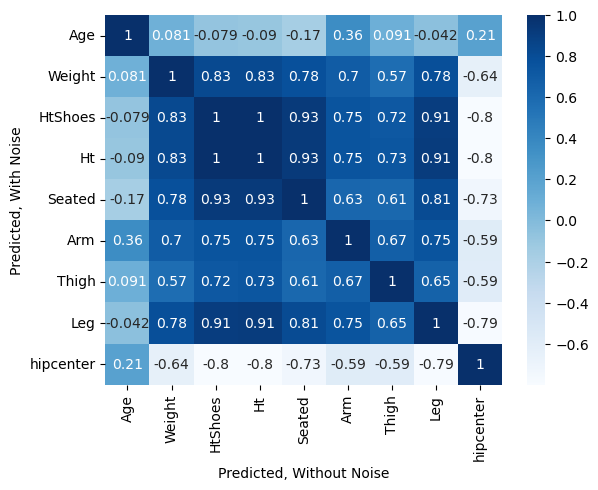

In [20]:
# Plotting
plt.scatter(hip_model.fittedvalues, hip_model_noise.fittedvalues, color='dodgerblue', s=30)
plt.xlabel('Predicted, Without Noise')
plt.ylabel('Predicted, With Noise')
plt.plot(hip_model.fittedvalues, hip_model.fittedvalues, color='darkorange', linewidth=2)
plt.show()


Si comparamos los valores predichos de ambos modelos, vemos que son bastante similares.

Veamos ahora un modelo más pequeño,


In [21]:
# hip_model_small
X_small = sm.add_constant(seatpos[['Age', 'Arm', 'Ht']])
hip_model_small = sm.OLS(seatpos['hipcenter'], X_small).fit()
print(hip_model_small.summary())

                            OLS Regression Results                            
Dep. Variable:              hipcenter   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     22.30
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           3.65e-08
Time:                        09:51:27   Log-Likelihood:                -188.10
No. Observations:                  38   AIC:                             384.2
Df Residuals:                      34   BIC:                             390.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        493.2491    101.072      4.880      0.0

In [22]:
# VIF for hip_model_small
vif_small = pd.Series([variance_inflation_factor(X_small.values, i) for i in range(X_small.shape[1])], index=X_small.columns)
print(vif_small)

const    297.575788
Age        1.749943
Arm        3.996766
Ht         3.508693
dtype: float64



Inmediatamente vemos que la multicolinealidad no es un problema aquí.


In [23]:
from statsmodels.stats.anova import anova_lm
table = anova_lm(hip_model_small, hip_model)
print(table)

   df_resid           ssr  df_diff      ss_diff         F    Pr(>F)
0      34.0  44353.689039      0.0          NaN       NaN       NaN
1      29.0  41261.783500      5.0  3091.905539  0.434617  0.820666



Obsérvese también que utilizando una prueba $F$ para comparar los dos modelos, preferiríamos el modelo más pequeño.

Ahora investigaremos el efecto de añadir otra variable a este modelo más pequeño. En concreto, queremos añadir la variable `HtShoes`. Así que ahora nuestros posibles predictores son `HtShoes`, `Age`, `Arm`, y `Ht`. Nuestra respuesta sigue siendo `centro de la cadera`.

Para cuantificar este efecto observaremos un **trazado de suma de variables** y un **coeficiente de correlación parcial**. Para ambos, observaremos los residuos de dos modelos:

- Regresión de la respuesta (`centro de la cadera`) contra todos los predictores
    excepto el predictor de interés (`HtShoes`).
- La regresión del predictor de interés (`HtShoes`) frente a los otros
    predictores (`Edad`, `Arm` y `Ht`).


In [24]:
# ht_shoes_model_small
ht_shoes_model_small = sm.OLS(seatpos['HtShoes'], X_small).fit()


Así que ahora, los residuos de `hip_model_small` nos dan la variación de `hipcenter` que es *unexplained* por `Age`, `Arm`, y `Ht`. Del mismo modo, los residuos de `ht_shoes_model_small` nos dan la variación de `HtShoes` no explicada por `Edad`, `Brazo` y `Ht`.

La correlación de estos dos residuos nos da el **coeficiente de correlación parcial** de `HtShoes` y el `centro de la cadera` con los efectos de `Edad`, `Brazo` y `Ht` eliminados.


In [25]:
# Correlation between residuals
corr, _ = pearsonr(ht_shoes_model_small.resid, hip_model_small.resid)
print(corr)

-0.03311061236881338



Como este valor es pequeño, cercano a cero, significa que la variación del `centro de la cadera` que no se explica por la `Edad`, el  `Brazo` " y el `Ht` muestra muy poca correlación con la variación del `HtShoes`  que no se explica por la `Edad`, el `Brazo` y el `Ht`. Por lo tanto, añadir  `HtShoes` al modelo probablemente sería poco beneficioso.

Del mismo modo, un **gráfico de variables añadidas** visualiza estos residuos entre sí. También es útil hacer una regresión de los residuos de la respuesta frente a los residuos del predictor y añadir la línea de regresión al gráfico.


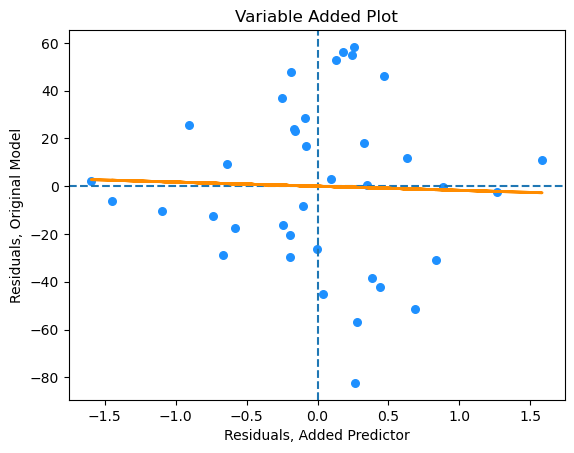

In [26]:
# Residuals plot
plt.scatter(ht_shoes_model_small.resid, hip_model_small.resid, color='dodgerblue', s=30)
plt.axhline(y=0, linestyle='--')
plt.axvline(x=0, linestyle='--')
plt.xlabel('Residuals, Added Predictor')
plt.ylabel('Residuals, Original Model')
plt.title('Variable Added Plot')

slope, intercept = np.polyfit(ht_shoes_model_small.resid, hip_model_small.resid, 1)
plt.plot(ht_shoes_model_small.resid, intercept + slope * ht_shoes_model_small.resid, color='darkorange', linewidth=2)
plt.show()


En este caso, el gráfico de variables añadidas no muestra prácticamente ninguna relación lineal. Esto nos indica que añadir `HtShoes` al modelo probablemente no merecería la pena. Dado que su variación se explica en gran medida por los otros predictores, añadirla al modelo no mejorará mucho el modelo. Sin embargo, aumentará la variación de las estimaciones y hará que el modelo sea mucho más difícil de interpretar.

Si hubiera existido una relación lineal fuerte y, por tanto, un coeficiente de correlación parcial elevado, probablemente habría sido útil añadir el predictor adicional al modelo.

En general, este equilibrio es cierto. A medida que un modelo tiene más predictores, los errores serán menores y su *predicción* será mejor, pero será más difícil de interpretar. Esta es la razón por la que, si estamos interesados en *explicar* la relación entre los predictores y la respuesta, a menudo queremos un modelo que se ajuste bien, pero con un pequeño número de predictores con poca correlación.

Proximamente aprenderemos métodos para encontrar modelos que se ajusten bien, pero que también tengan un pequeño número de predictores. También hablaremos del *sobreajuste*. Aunque añadir predictores adicionales siempre reducirá los errores, a veces estaremos "ajustando el ruido" y dicho modelo no se generalizará bien a observaciones adicionales.
